# Yewno: Data Science Assignment
### Abhijit Nair | anair5@uncc.edu | December 14th

## Problem Statement
Develop a system for plagiarism detection: you are given a set of textual documents and you are asked to detect which documents contain significant overlapping in content. It is up to you to define what "significant" and "overlapping" mean. You can also use examples of plagiarized portions of documents.


## Approach

In this assignment I have used Fingerprinting Technique - which involves creating a set of fingerprints for each Document and checking for overlaps in this fingerprint.
This approach will detect any copied sentence, minimum length of the sentence is set by the user.
I have set significance as 12 words, i.e. if some one copies a sentence, if the sentence length is below 12, there is a chance that the algorithm will catch it, depending on the size of the k-gram, and if the sentence length is above 12, this algorithm will detect it with 100% accuracy.

Test cases are created to prove this, and also to show how fingerprinting is better than cosine similarity when it comes to plagiarism detection.


## Why Fingerprinting 

Fingerprinting is a highly scalable technique - and is excellent for checking partial copies. Other bag of word approaches, and/or similarity metrics like cosine similarity are good at finding similar topics but are less reliable when it comes to plagiarism detection. 

## Implementation
I used the winnowing algorithm to select the fingerprints for my documents.<br> 
The original paper can be found in this link: http://www.cs.princeton.edu/courses/archive/spr05/cos598E/bib/p76-schleimer.pdf
One Fingerprint is a k-gram, k chosen by the user.<br>

Formula   $t=w+k-1$ <br>
Here $t$ is the guarantee threshold, what this means is that if a line which has $t$ number of words is copied, then the match is detected for sure.<br>
$k$ is the noise threshold, any number of words less than $k$ if copied, will not be detected by our system.<br>
Once these two parameters are set we can calculate the window size $w$, what this means is that, we select at least one k-gram from each window, thus ensuring the guarantee threshold. The k-grams are hashed using python's hash( ) function and this set of selected hashes stored as the fingerprint for the document.

### Data-Preprocessing 

#### Acquiring the Data 
- I used arxiv's api to get a list of papers from a topic and then randomly sampled 90 papers from this. Then I used the pdfx package to extract the text. all images were discarded. 
- Issue Encountered: 
     - Some of the pdfs could not be converted and were discarded

#### Data Cleaning
- Converted all characters to lower case.
- Removed all the new-line and line break characters. 
- Removed the Reference section from 90% of the papers, i.e. papers which had Reference as a heading. This was done because many papers might use the same reference, but this is not a sign of plagiarism. 
- All numbers and equations were removed because papers can have similar equations and numbers.
- All texts in quotes was removed.
- The words were stemmed 
- Words of length below 2 were discarded.
- Period was used to split lines into sentences
- Issues Encountered:
    - Pulling out reference not possible with regex, so first converted all '\n' to # and then matched all characters that come after 'Reference#'

### Determining the parameters

I chose my $k$, noise threshold as 5, any sequence of words less than 5 was not worth investigation.
I dropped all sentences which had less than 5 words.

To determine the parameters $t$ and $w$,

I plotted the average number of words per sentence in all documents. The average number was around 24. I chose half of that as my guarantee threshold. The corresponding windows size was 8.

### K-Gram Index

Each sentence is converted to k-grams. if there are $n$ number of words in a sentence then it will have $n-k+1$ number of k-grams. <br>
Once the k-grams are created, each K-gram is hashed and the k-gram alone with the document number and the sentence number is pickled. This step is time consuming, but once it is pickled, we don't have to recompute it.

### Winnowing

For each sentence, the k-grams are taken and depending on the window size, one hash is taken from each window.<br>
If the window size is smaller than the number of k-grams in a sentence, then we choose one k-gram from the sentence. The smallest hash value is always chosen from a window as this value has a high probability of being the smallest in the consecutive window. 
I chose minimum hash from all windows, and if consecutive hash are same, then ignored those hash.
<br>
<br>
<br>
<br>



![Screenhot](./Capture.PNG)

<br>
<br>
<br>
<br>

This image is taken from the winnowing paper, the same algorithm is applied here, the only difference is that we have done it at a word level and not at character level.
This technique ensures that we have the smallest number of fingerprints while maintaining the guaranteed threshold.

### Test Cases
I created some test scenarios to show how the algorithm works. The test files are numbered test1 (id:100), test2 (id:101),test3 (id:102) and test4 (id:103).<br>
- test1 (id:100): Extract from wikipedia about a random topic, I also added just one sentence of length greater than 12. This will show how the algorithm works, even if it is just a sentence.
- test2 (id:101): Extract from a random wiki article, but I added sequence of words, less than our noise level. This should not be detected as plagiarism by out system.
- test3 (id:102): More than 50% plagiarised.
- test4 (id:103): Not plagiarised, but similar topic as test1 - to show how fingerprinting is a better approach than cosine.

## Results

- Test1 was a success - the copied line was caught by the system
- Test 2 was a success - There was no match, it was not detected by the system.
- Test 3 was captured by the system.
- Test 4 as a success
Documents 76 and 77 was flagged as plagiarised, but upon manual inspection, these were papers in a similar topic, written by same authors. This was a False positive.

#### Comparison with cosine similarity.
Document 101 and Document 103 had a high cosine similarity, but were not plagiarised. Document 100 and Document 0 had a smaller cosine similarity, but this had plagiarism. It is hard to determine what the cut off for cosine similarity should be and to find out where exactly it was plagiarised from. Fingerprinting will give us the exact sentence.
Calculating k-gram cosine similarity for large number of documents is competitively expensive, fingerprinting is highly scalable.




## Assessing the Performance
- Using the above test cases we can see that we have one false positive. The test cases provided by me were successfully captured by the system, as long as there was no plagiarism in the initial 90 docs, we can say that there are no false negatives. 

## Potential pitfalls
- The approach here works for copy paste plagiarism, changing the word, i.e. idea plagiarism is not captured.
- Same Author can write similar papers and this will be flagged as plagiarism. (false Positive)
- Same can be said about multiple authors.
- Images and equations are excluded.
- If the plagiarised sentences are enclosed in quotes, the algorithm won't capture this.

## How could malicious authors potentially fool your system?
- Synonyms for copied sentence
- Changing the sentence structure completely
- Copying the paper the a different language
- Enclosing the plagiarised part in quotes
- Plagiarising Images - adding screenshots of a different paper.

## Scalability
- This system is scalable, the bottle necks would be creating the k-gram index, using a hash that is large enough to avoid false positives. The same algorithm can be implemented on spark, with the papers stored in HDFS and k-gram index stored in memory

## Future Work
- Use a set of commonly used synonyms as a list to check against for authors who change words.
- take the author and co-author informations to avoid false positives.
- Run different combinations of $t$, $k$ and $w$ to find the optimal values, this would be the ones that minimize False Negatives.
- Add more test cases and check the limitations of the system
- Implementation of the winnowing algorithm on distributed systems. (PySpark)

# Code

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
pd.set_option('display.max_colwidth', -1)
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
import random
import os
import pdfx
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import arxiv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [12]:
def download_pdf(term, k):
    """
    This function uses the arxiv package and the axriv api to query a search term "term" and
    randomly sample k terms and download the pdf.
    """
    search_query = arxiv.query(search_query="earth", max_results=10000)
    rand_items = random.sample(search_query, k)
    for i in range(0, k):
        arxiv.download(obj=rand_items[i], dirname='./pdf/', slugify=True)


def pdf_path():
    """
    Returns the names of the downloaded pdf files
    """
    pdfFiles = []
    for filename in os.listdir('./pdf/'):
        if filename.endswith('.pdf'):
            pdfFiles.append(filename)
    return pdfFiles


def read_data(pdfFiles):
    """
    This function extracts text from pdf and stores in a dataframe along with filename. 
    Returns the dataframe
    """
    df = pd.DataFrame([])
    invalid_pdf = []
    i = 0
    for filename in pdfFiles:
        try:
            pdf = pdfx.PDFx((os.path.join('./pdf/', filename)))
            df = df.append(
                pd.DataFrame(
                    {
                        'papername': filename,
                        'text': pdf.get_text()
                    }, index=[i]))
            i = i + 1
        except:
            invalid_pdf.append(filename)
            continue
    return df


def clean(df):
    """
    This function cleans the text extracted from the pdf and returns it.
    """
    #make all the text to lower case
    df.text = df.text.str.lower()
    #replace new-line with # for easier cleaning
    df['cleaned'] = df.text.apply(lambda x: re.sub(r"\n", "#", x))
    #Remove references from the text
    df['cleaned'] = df.cleaned.apply(lambda x: re.sub(r'references#.*', "", x))
    #Remove Bibliography from the text
    df['cleaned'] = df.cleaned.apply(
        lambda x: re.sub(r'bibliography#.*', "", x))
    #Replace pound unwanted charecters with space
    df['cleaned'] = df.cleaned.apply(lambda x: re.sub(r"#", " ", x))
    df['cleaned'] = df.cleaned.apply(lambda x: re.sub(r"\t", " ", x))
    df['cleaned'] = df.cleaned.apply(lambda x: re.sub(r"\r", " ", x))
    #Keep only alphabets, fullstops and white spaces
    df['cleaned'] = df.cleaned.apply(
        lambda x: re.sub(r'([^a-zA-Z."\s]+)', " ", x))
    #Remove all text inside quotes
    df['cleaned'] = df.cleaned.apply(lambda x: re.sub(r'\"(.+?)\"', " ", x))
    #Strip all extra white spaces
    df['cleaned'] = df.cleaned.apply(lambda x: re.sub(r"([\s]{2,})", " ", x))
    return df


def clean_step2(df):
    """
    This function performs, stemming and removes all words with length less than 2
    and splits the text into sentences
    """
    stemmer = SnowballStemmer("english")
    df.cleaned = df['cleaned'].apply(
        lambda x: ' '.join([word for word in x.split() if len(word) > 2]))
    df.cleaned = df['cleaned'].apply(
        lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
    df['cleaned'] = df.cleaned.apply(lambda x: re.sub(r"([\s]{2,})", " ", x))
    df['cleaned_split'] = df.cleaned.apply(lambda x: x.split('. '))
    return df


def avg_wordpl(doc):
    """
    Function calculates and returns average number of words per sentence.
    """
    wrd = 0
    ln = 0
    for line in doc:
        wrd += len(line.split())
        ln += 1
    return (round(wrd / ln))


def drop_sen(doc, k):
    """
    Function to drop all sentences that have words less than k-grams
    """
    sentence = [line for line in doc if len(line.split()) > 5]
    return sentence


def apply_kgram(doc, k):
    """
    Takes a document and the number of grams as input and returns the kgram list as output
    """
    doc_kgram = []
    for line in doc:
        doc_kgram.append(make_kgrams(line, k))
    return doc_kgram


def make_kgrams(sentence, k):
    """
    Takes a sentence and number of grams as input and returns the k-gram for that sentence as output
    """
    words = sentence.split()
    zip_list = zip(*[words[i:] for i in range(k)])
    list_z = [list(a) for a in zip_list]
    return [' '.join(list(i)) for i in list_z]


def kgram_indexer(df):
    """
    Creates a dataframe of K_grams and corresponding document number and sentence number
    """
    kgram_index = pd.DataFrame([])
    d = 1
    for doc in df.kgrams:
        s = 1
        for sen in doc:
            for kgram in sen:
                kgram_index = kgram_index.append(
                    pd.DataFrame(
                        {
                            'kgram': kgram,
                            'sentence': s,
                            'doc': d
                        }, index=[0]),
                    ignore_index=True)
            s += 1
        d += 1
    return kgram_index


def fingerprinting(df, w):
    """
    This Function takes the windows size and performs the winnowing algorithm. Returns the fingerprint.
    """
    kg = []
    fingerprint = pd.DataFrame([])
    for d in range(max(df.doc) + 1):
        doc = df[df.doc == d]
        for i in range(max(doc.sentence) + 1):
            kg = list(doc[doc.sentence == i].hash)
            if (len(kg) < w):
                fingerprint = fingerprint.append(
                    pd.DataFrame(
                        {
                            'fingerprint': min(kg),
                            'doc_num': d,
                            'sentence_no': i
                        },
                        index=[0]),
                    ignore_index=True)
            else:
                for j in range((len(kg) - w + 1)):
                    fingerprint = fingerprint.append(
                        pd.DataFrame(
                            {
                                'fingerprint': min(kg[j:j + w]),
                                'doc_num': d,
                                'sentence_no': i
                            },
                            index=[0]),
                        ignore_index=True)
    return fingerprint


def shifting(df):
    """
    Function removes similar consecutive hashes and outputs the final fingerprint dataframe 
    """
    shifted = df.fingerprint.loc[df.fingerprint.shift(-1) != df.fingerprint]
    df_final = pd.DataFrame([])
    for i in shifted.index:
        df_final = df_final.append(
            pd.DataFrame(
                {
                    'fingerprint': df_fingerprint.iloc[i].fingerprint,
                    'doc_num': df_fingerprint.iloc[i].doc_num,
                    'sentence_no': df_fingerprint.iloc[i].sentence_no
                },
                index=[0]),
            ignore_index=True)
    return df_final


def test_path():
    """
    Returns the names of the test files
    """
    testFiles = []
    for filename in os.listdir('./Test//'):
        if filename.endswith('.txt'):
            testFiles.append(filename)
    return testFiles


def read_testdata(testFiles):
    """
    This function extracts text from pdf and stores in a dataframe along with filename. 
    Returns the dataframe
    """
    df = pd.DataFrame([])
    i = 0
    for filename in testFiles:
        try:
            file = open((os.path.join('./Test/', filename)), "r")
            df = df.append(
                pd.DataFrame(
                    {
                        'papername': filename,
                        'text': file.read()
                    }, index=[i]))
            i = i + 1
        except:
            invalid_pdf.append(filename)
            continue
    return df


def comparison(result):
    """
    Checks for overlaps in fingerprints
    """
    dk = []
    for i in range(max(result.doc_num) + 1):
        dk.append(
            result[result.doc_num == i].fingerprint.values.flatten().tolist())

    setdk = []
    for i in dk:
        setdk.append(set(i))

    dic = {}
    for i in range(0, len(setdk)):
        list_of_matches = []
        for j in range(i + 1, len(setdk)):
            fir = setdk[i].intersection(setdk[j])
            if fir:
                list_of_matches.append((j, fir))
        dic[i] = list_of_matches
        plag = pd.DataFrame([])
    for doc, match in dic.items():
        for l in match:
            if len(l[1]) > 2:
                plag = plag.append(
                    pd.DataFrame(
                        {
                            'doc_num': doc,
                            'match_doc': l[0],
                            'match_print': l[1]
                        },
                        index=[0]),
                    ignore_index=True)
    for i, row in plag.iterrows():
        plag.match_print[i] = list(plag.match_print[i])
    return plag


def getcommonsentence(plag):
    """
    Gets the sentence which was plagiarised, depending on the fingerprint
    """
    plag['CopiedSentence'] = ""
    for i, row in plag.iterrows():
        sen = []
        for fprint in row.match_print:
            z = row.doc_num
            x = min(kgram_index[kgram_index.hash == fprint].sentence)
            sen.append(df.dropped[z][x])
        plag['CopiedSentence'][i] = sen
    plag.CopiedSentence = plag.CopiedSentence.apply(lambda x: list(set(x)))
    plag['NumberOfCopied'] = plag.CopiedSentence.apply(lambda x: len(x))
    return plag

In [6]:
#pd.to_pickle(df,"text.pkl")
df = pd.read_pickle('text.pkl')
df = clean(df)
df = clean_step2(df)
#Dropping documents with parse issues
df.drop([75, 85, 87], inplace=True)
df.reset_index(inplace=True)

### Plot - Average number of words per sentence - before dropping sentences below k

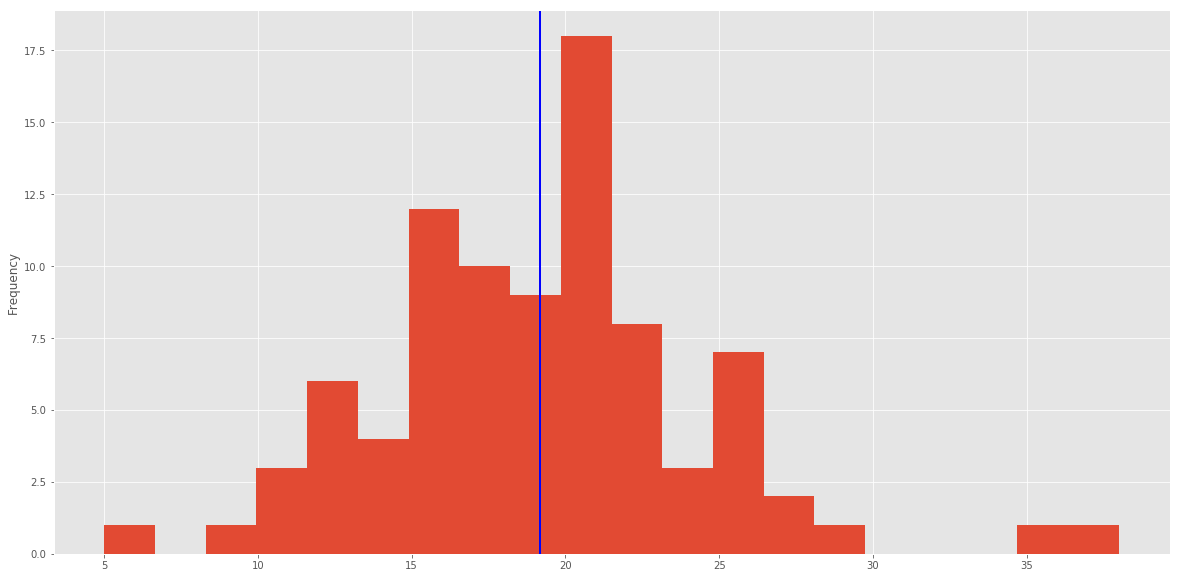

In [6]:
avg_len = df.cleaned_split.apply(avg_wordpl)
p = avg_len.plot(kind='hist', bins=20)
p.axvline(avg_len.mean(), color='blue', linewidth=2)

In [9]:
#Dropping sentences with words less than our noise threshold
df['dropped'] = df.cleaned_split.apply(lambda x: drop_sen(x, 5))

### Plot - Average number of words per sentence - after dropping sentences below k

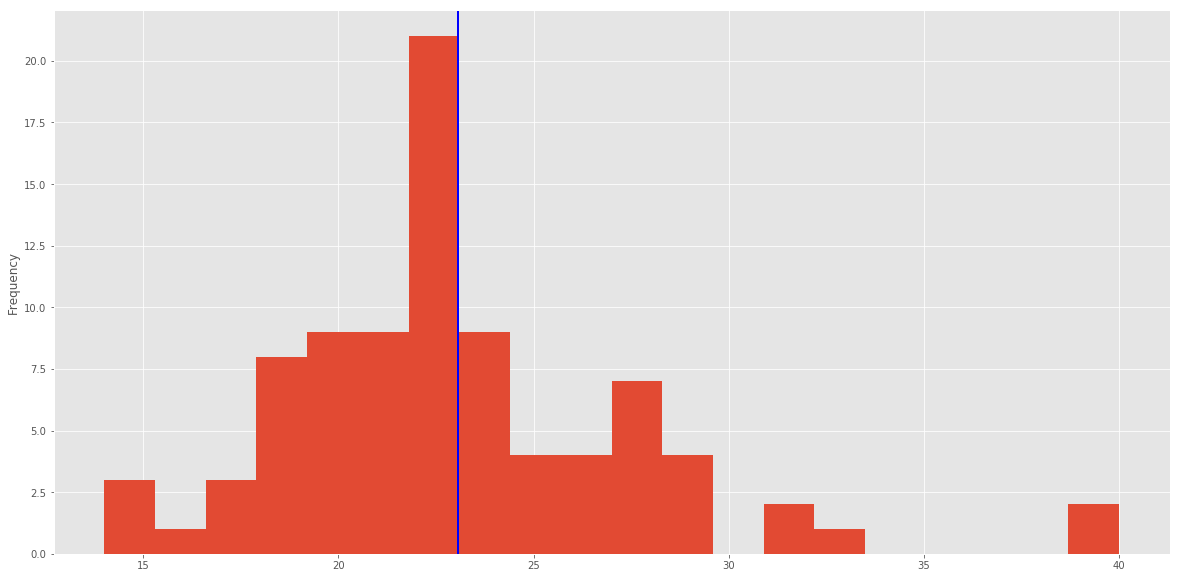

In [10]:
avg_len = df.dropped.apply(avg_wordpl)
p = avg_len.plot(kind='hist', bins=20)
p.axvline(avg_len.mean(), color='blue', linewidth=2)

## Creating the Fingerprints and pickling them

In [11]:
#make the k-grams for each sentence
df['kgrams'] = df.dropped.apply(lambda x: apply_kgram(x, 5))

#kgram_index = kgram_indexer(df)

#pd.to_pickle(kgram_index,'kgram_index.pkl')
kgram_index = pd.read_pickle('kgram_index2.pkl')
kgram_index['hash'] = kgram_index.kgram.apply(hash)

#performing the hashing and winnowing
kgram_index['hash'] = kgram_index.kgram.apply(hash)

%time df_fingerprint=fingerprinting(kgram_index,8)

%time df_fingerprint=shifting(df_fingerprint)

## Reading in the test cases and preprocessing them

In [ ]:
testFiles = test_path()
df_test = read_testdata(testFiles)
df_test = clean(df_test)
df_test = clean_step2(df_test)
#df_test.to_pickle('testcase.pkl')

df_test = pd.read_pickle('testcase.pkl')
df_test['dropped'] = df_test.cleaned_split.apply(lambda x: drop_sen(x, 5))
df_test['kgrams'] = df_test.dropped.apply(lambda x: apply_kgram(x, 5))
kgram_index_test = kgram_indexer(df_test)
#pd.to_pickle(kgram_index_test,'kgram_index_test.pkl')

In [51]:
kgram_index_test = pd.read_pickle('kgram_index_test.pkl')
kgram_index_test['hash'] = kgram_index_test.kgram.apply(hash)
df_fingerprint_test = fingerprinting(kgram_index_test, 8)
df_final_test = shifting(df_fingerprint)
df_final_test.doc_num = df_final_test.doc_num + 100
result = pd.concat([df_fingerprint, df_final_test])
#result.to_pickle('testtrainfingerprint.pkl')

In [13]:
result = pd.read_pickle('testtrainfingerprint.pkl')

In [40]:
#output = comparison(result)
#output=getcommonsentence(output)
#output.to_pickle('FinalResult.pkl')
output = pd.read_pickle('FinalResult.pkl')

## The matched docs, along with the copied sentence and number of copied sentences

In [45]:
output[['doc_num', 'match_doc', 'CopiedSentence', 'NumberOfCopied']]

doc_num  match_doc  \
0  0        100         
1  3        36          
2  12       58          
3  12       66          
4  13       102         
5  36       79          
6  76       77          

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

## Comparison with cosine similarity

In [102]:
# pulling out the docs we got in the above result and creating a tf-idf matrix
sim = pd.DataFrame([])
for i in range(5):
    if i == 0:
        sim = sim.append(
            pd.DataFrame({
                'doc_num': i,
                'text': df.cleaned[i]
            }, index=[0]),
            ignore_index=True)
    else:
        sim = sim.append(
            pd.DataFrame(
                {
                    'doc_num': i + 99,
                    'text': df_test.cleaned[i + 99]
                },
                index=[0]),
            ignore_index=True)
#sim.set_index('doc_num',inplace=True,drop=True)

tokenizer = RegexpTokenizer(r'\w+')
tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenizer.tokenize)
tfidf_matrix = tfidf_vectorizer.fit_transform(sim.text)

cs = cosine_similarity(tfidf_matrix)

##  Cosine similarity matrix

In [103]:
cm = pd.DataFrame(cs, index=sim.doc_num, columns=sim.doc_num)
cm

doc_num,0,100,101,102,103
doc_num,,,,,
0,1.000000,0.448433,0.414117,0.352229,0.439734
100,0.448433,1.000000,0.651156,0.323382,0.630737
101,0.414117,0.651156,1.000000,0.284402,0.613193
102,0.352229,0.323382,0.284402,1.000000,0.314419
103,0.439734,0.630737,0.613193,0.314419,1.000000
